In [139]:
import pandas as pd
import numpy as np
import numpy.linalg as la
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.base import clone
import timeit
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [140]:
def pca(F, X):
    n, d = X.shape
    mu = np.zeros((d, 1))
    Z = np.zeros((d, F))
    for i in range(d):
        mu[i] = (1. / n) * np.sum(X[:, [i]])
    X = X - mu.T
    U, s, Vt = la.svd(X, False)
    g = s[:F]
    for i in range(F):
        g[i] = 1. / g[i]
    W = Vt[:F]
    Z = np.dot(W.T, np.diag(g))
    return (mu, Z)

def pca_proj(X,mu,Z):
    n, d = X.shape
    X = X - mu.T
    return np.dot(X, Z)

In [141]:
def k_fold(k, model, f, X, y, error_type="mse"):
    n, d = X.shape
    z = np.zeros((k, 1))
    for i in range(k):
        T = list(range(int((i * n) / k), int((n * (i + 1) / k))))
        S = [j for j in range(n) if j not in T]
        curr_model = clone(model)

        training_mu, training_Z = pca(f, X[S])
        training_X = pca_proj(X[S], training_mu, training_Z)

        curr_model.fit(training_X, y[S])

        test_X = pca_proj(X[T], training_mu, training_Z)

        # y[T] will be len(T) by 1
        # X[T] will be len(T) by d
        if error_type == "mse":
            z[i] = (1. / len(T)) * np.sum((y[T] - curr_model.predict(test_X)) ** 2)
        elif error_type == "log_mse":
            z[i] = (1. / len(T)) * np.sum((np.log(y[T] + 1) - np.log(curr_model.predict(test_X) + 1)) ** 2)
    return z

In [142]:
def bootstrapping(B, model, f, X, y, error_type="mse"):
    n, d = X.shape
    z = np.zeros((B, 1))
    for i in range(B):
        u = np.random.choice(n, n, replace=True)
        S = np.unique(u)
        T = np.setdiff1d(np.arange(n), S, assume_unique=True)
        curr_model = clone(model)

        training_mu, training_Z = pca(f, X[u])
        training_X = pca_proj(X[u], training_mu, training_Z)

        curr_model.fit(training_X, y[u])

        test_X = pca_proj(X[T], training_mu, training_Z)

        # y[T] will be len(T) by 1
        # X[T] will be len(T) by d
        # theta_hat will be d by 1
        if error_type == "mse":
            z[i] = (1. / len(T)) * np.sum((y[T] - curr_model.predict(test_X)) ** 2)
        elif error_type == "log_mse":
            z[i] = (1. / len(T)) * np.sum((np.log(y[T] + 1) - np.log(curr_model.predict(test_X) + 1)) ** 2)
    return z

In [143]:
def evaluate_model(model, f, X, y, k=5, B=5):
    ######################## KFOLD ###################
    print('Evaluating K-fold with %d folds.' % k)
    start_time = timeit.default_timer()
    k_fold_z = k_fold(k, model, f, X, y, error_type="log_mse")
    elapsed = timeit.default_timer() - start_time
    
    k_fold_mse = np.mean(k_fold_z)
    print('K-fold Mean Squared log Error: ', k_fold_mse)
    
    k_fold_rmse = math.sqrt(k_fold_mse)
    print('K-fold Square Root Mean Squared log Error: ', k_fold_rmse)

    print("Time elapsed for k-fold: ", elapsed)

    print()
    print()
    
    ################### BOOTSTRAPPING ################
    print('Evaluating bootstrapping with %d bootstraps.' % B)
    start_time = timeit.default_timer()
    bootstrapping_z = bootstrapping(B, model, f, X, y)
    elapsed = timeit.default_timer() - start_time

    bootstrapping_mse = np.mean(bootstrapping_z)
    print('Bootstrapping Mean Squared Error: ', bootstrapping_mse)

    bootstrapping_rmse = math.sqrt(bootstrapping_mse)
    print("Time elapsed for bootstrapping: ", elapsed)
    
    return (k_fold_z, k_fold_mse, k_fold_rmse, bootstrapping_z, bootstrapping_mse, bootstrapping_rmse)

# Data Processing

In [144]:
print()
print("========== Data Processing ==========")
print()


========== Data Processing ==========



In [145]:
data = pd.read_csv("train.csv", header=0)
print(data.shape)

X = data.iloc[:,:-1]
Y = data.iloc[:,-1:]

print(X.shape)
print(Y.shape)

(1460, 81)
(1460, 80)
(1460, 1)


In [146]:
print("Print features with null values:")
# this just sums up how many nulls per feature and divides to find percentage of nulls per feature
# if over 50% null then print the feature
data_keys = X.keys()
for i, b in enumerate((X.isnull().sum() / X.shape[0]) > 0.5):
    if b:
        print(data_keys[i])

Print features with null values:
Alley
PoolQC
Fence
MiscFeature


In [147]:
print("Replace categorical Values with numerical scale:\n")
# Replaces categorical value in Quality columns with numerical scale
qualityCols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
              'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

data[qualityCols].head()

for col in qualityCols:
    # NA is never used since all NA's got converted to NaN objects when pandas read in the csv
    data[col] = data[col].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1, 'NA': 0})

data[qualityCols].head()

Replace categorical Values with numerical scale:



,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond
0,4,3,4.0,3.0,5,4,NaN,3.0,3.0
1,3,3,4.0,3.0,5,3,3.0,3.0,3.0
2,4,3,4.0,3.0,5,4,3.0,3.0,3.0
3,3,3,3.0,4.0,4,4,4.0,3.0,3.0
4,4,3,4.0,3.0,5,4,3.0,3.0,3.0


In [148]:
# categorical columns
catCols = set(list(X))-set(list(X._get_numeric_data()))
print(catCols)

#Fill Categorical Column Null values with 0
for col in catCols:
    data[col].fillna(0, inplace=True)

#Fill numerical column null values with mean of column
data = data.fillna(data.mean())

{'GarageFinish', 'GarageType', 'RoofStyle', 'BsmtFinType2', 'KitchenQual', 'Foundation', 'ExterQual', 'Condition2', 'Alley', 'Electrical', 'LandSlope', 'PoolQC', 'LotShape', 'LandContour', 'PavedDrive', 'BsmtExposure', 'Utilities', 'SaleCondition', 'CentralAir', 'Condition1', 'BsmtQual', 'ExterCond', 'HouseStyle', 'BldgType', 'LotConfig', 'Exterior1st', 'Street', 'Heating', 'FireplaceQu', 'RoofMatl', 'Fence', 'MasVnrType', 'HeatingQC', 'MiscFeature', 'SaleType', 'Exterior2nd', 'BsmtFinType1', 'BsmtCond', 'Functional', 'GarageQual', 'MSZoning', 'GarageCond', 'Neighborhood'}


In [149]:
#Perform one hot encoding on all categorical columns
frames = []
for col in catCols:
    oneHot_encoded = pd.get_dummies(X[col])
    oneHot_encoded = oneHot_encoded.add_prefix(col + '_is_')
    frames.append(oneHot_encoded)

X = X.drop(catCols, axis=1)

X = pd.concat(frames, axis=1)

In [150]:
X.keys()

Index(['GarageFinish_is_Fin', 'GarageFinish_is_RFn', 'GarageFinish_is_Unf',
       'GarageType_is_2Types', 'GarageType_is_Attchd', 'GarageType_is_Basment',
       'GarageType_is_BuiltIn', 'GarageType_is_CarPort',
       'GarageType_is_Detchd', 'RoofStyle_is_Flat',
       ...
       'Neighborhood_is_NoRidge', 'Neighborhood_is_NridgHt',
       'Neighborhood_is_OldTown', 'Neighborhood_is_SWISU',
       'Neighborhood_is_Sawyer', 'Neighborhood_is_SawyerW',
       'Neighborhood_is_Somerst', 'Neighborhood_is_StoneBr',
       'Neighborhood_is_Timber', 'Neighborhood_is_Veenker'],
      dtype='object', length=252)

In [151]:
X.isnull().values.any()

False

In [152]:
# 80:20 train test ratio
test_size = 0.2
# This function splits the training and target sets into random train and test subsets.
# X_train and X_test are subsets of the training data
# y_train and y_test are subsets the the target data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

# PCA Feature Selection

In [153]:
# This value was determined based on the PCA Plots generated below
F = 50
f = 50

In [154]:
X_mu, X_Z = pca(F, X.values)
X_pca = pca_proj(X.values, X_mu, X_Z)

In [155]:
print(X_mu.shape)
print(X_Z.shape)
print(X_pca.shape)

(252, 1)
(252, 50)
(1460, 50)


In [100]:
X_train_mu, X_train_Z = pca(F, X_train.values)

In [101]:
print(X_train_mu.shape)
print(X_train_Z.shape)

(252, 1)
(252, 50)


In [102]:
X_train_pca = pca_proj(X_train.values, X_train_mu, X_train_Z)
print(X_train_pca.shape)

X_test_pca = pca_proj(X_test.values, X_train_mu, X_train_Z)
print(X_test_pca.shape)

(1168, 50)
(292, 50)


# AdaBoost

In [158]:
print()
print("========== AdaBoost ==========")
print()
from sklearn.ensemble import AdaBoostRegressor
adaBoost = AdaBoostRegressor()
k_z, k_mse, k_rmse, b_z, b_mse, b_rmse = evaluate_model(adaBoost, f, X.values, Y.values.ravel(), k=5, B=5)

adaBoost = AdaBoostRegressor(n_estimators=25)
adaBoost.fit(X_train_pca, y_train.values.ravel())
adaBoost.score(X_test_pca, y_test.values.ravel())


========== AdaBoost ==========

Evaluating K-fold with 5 folds.
K-fold Mean Squared log Error:  0.08289387022210948
K-fold Square Root Mean Squared log Error:  0.28791295598168115
Time elapsed for k-fold:  2.5979019999995216


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  2727658745.7575235
Time elapsed for bootstrapping:  2.776842000000215


-0.07872082958762894

In [104]:
#View Predicted values
predicted = adaBoost.predict(X_test_pca)
ada_pred = y_test.copy()
ada_pred['predicted'] = predicted
ada_pred.head()

,SalePrice,predicted
1082,192000,221313.425000
740,132000,144750.351178
954,127500,184678.090909
1323,82500,167509.414226
856,147000,152360.639175


# XGBoost Regressor

In [159]:
print()
print("========== XgBoost ==========")
print()

from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=70)
k_z, k_mse, k_rmse, b_z, b_mse, b_rmse = evaluate_model(xgb, f, X.values, Y.values.ravel(), k=5, B=5)

xgb.fit(X_train_pca, y_train)
xgb.score(X_test_pca, y_test.values.ravel())


========== XgBoost ==========

Evaluating K-fold with 5 folds.
K-fold Mean Squared log Error:  0.04850286442373754
K-fold Square Root Mean Squared log Error:  0.22023365869852304
Time elapsed for k-fold:  1.700275000000147


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  2046037620.4376779
Time elapsed for bootstrapping:  1.9376900000006572


-0.10250026542820212

In [160]:
predicted = xgb.predict(X_test_pca)
xgb_pred = y_test.copy()
xgb_pred['predicted'] = predicted
xgb_pred.head()

,SalePrice,predicted
1291,119500,182656.171875
1240,224900,218658.171875
690,141000,147633.968750
706,302000,165326.359375
208,277000,146229.109375


# SVM (SVR)

In [161]:
print()
print("========== SVR ==========")
print()

from sklearn import svm
svr_model = svm.SVR(kernel="poly", coef0=-3500, gamma="auto")
# coef0 only works with poly and sigmoid kernels
# it just puts that value instead of the column of 1's

# without it, this model breaks for some reason

k_z, k_mse, k_rmse, b_z, b_mse, b_rmse = evaluate_model(svr_model, f, X.values, Y.values.ravel(), k=5, B=5)

# epsilon, degree
svr_model.fit(X_train_pca, y_train.values.ravel())
svr_model.score(X_test_pca, y_test.values.ravel())


========== SVR ==========

Evaluating K-fold with 5 folds.
K-fold Mean Squared log Error:  0.054210540665989494
K-fold Square Root Mean Squared log Error:  0.2328315714545377
Time elapsed for k-fold:  1.3860459999996237


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  2811506486.24859
Time elapsed for bootstrapping:  1.9106480000000374


-0.06465747808979527

In [162]:
svr_predicted = svr_model.predict(X_test_pca)
svr_pred = y_test.copy()
svr_pred["predicted"] = svr_predicted
svr_pred.head()

,SalePrice,predicted
1291,119500,182512.212828
1240,224900,166571.869490
690,141000,168356.692336
706,302000,149207.762129
208,277000,169859.534880


# Hyperparameter Tuning

In [163]:
#This takes time (~2mins)
def tune_hyperparameters():
    adaboost_param_tuning = pd.DataFrame(columns=['parameter', 'rmse'])
    xgb_param_tuning = pd.DataFrame(columns=['parameter', 'rmse'])    
    svr_param_tuning = pd.DataFrame(columns=['parameter', 'rmse'])    

    #Tuning n estimators parameter for boosting algorithms
    for i in range(25,200,25):
        print("Boosting: " + str(i))
        adaBoost = AdaBoostRegressor(n_estimators=i)
        print(adaBoost)
        k_fold_z, k_fold_mse, k_fold_rmse, bootstrapping_z, bootstrapping_mse, bootstrapping_rmse = evaluate_model(adaBoost, f, X_pca, Y.values.ravel(), k=5, B=5)
        adaboost_param_tuning = adaboost_param_tuning.append({'parameter': i, 'rmse': k_fold_rmse}, ignore_index=True)
        xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=i)
        k_fold_z, k_fold_mse, k_fold_rmse, bootstrapping_z, bootstrapping_mse, bootstrapping_rmse = evaluate_model(xgb, f, X_pca, Y.values.ravel(), k=5, B=5)
        xgb_param_tuning = xgb_param_tuning.append({'parameter': i, 'rmse': k_fold_rmse}, ignore_index=True)
        
    #for i in range(25,200,25):
    c_vals = [0.01, 0.1, 10, 100]
    for i in c_vals:
        print("C: " + str(i))
        svr_model = svm.SVR(kernel="poly", coef0=-3500, gamma="auto", C=i)
        k_fold_z, k_fold_mse, k_fold_rmse, bootstrapping_z, bootstrapping_mse, bootstrapping_rmse = evaluate_model(svr_model, f, X_pca, Y.values.ravel(), k=5, B=5)
        svr_param_tuning = svr_param_tuning.append({'parameter': i, 'rmse': k_fold_rmse}, ignore_index=True)

    return xgb_param_tuning, adaboost_param_tuning, svr_param_tuning

In [164]:
print()
print("========== Hyper-Parameter Tuning ==========")
print()

xgb_params, adaboost_params, svm_params = tune_hyperparameters()

print()
print("*** Hyper-parameter Tuning Complete! ***")
print()

========== Hyper-Parameter Tuning ==========

Boosting: 25
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=25, random_state=None)
Evaluating K-fold with 5 folds.
K-fold Mean Squared log Error:  0.12399349589016047
K-fold Square Root Mean Squared log Error:  0.35212710189668794
Time elapsed for k-fold:  1.5105579999999463


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  4269602067.879049
Time elapsed for bootstrapping:  1.6587749999998778
Evaluating K-fold with 5 folds.
K-fold Mean Squared log Error:  0.08543503581660142
K-fold Square Root Mean Squared log Error:  0.29229272282525515
Time elapsed for k-fold:  0.689209000000119


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  2843607348.7152886
Time elapsed for bootstrapping:  0.740802000000258
Boosting: 50
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)
Evalu

# Plots

## PCA Plot

In [176]:
# This takes time to run (~5mins)
def pca_tuning(F, X, Y, X_train, y_train, X_test, y_test):
    
    pca_ada_frame = pd.DataFrame(columns=['pca', 'rmse'])
    pca_xg_frame = pd.DataFrame(columns=['pca', 'rmse'])
    pca_svr_frame = pd.DataFrame(columns=['pca', 'rmse'])
    
    for f in F:
        print("\nPCA %d" % f)

        X_mu, X_Z = pca(f, X.values)
        X_pca = pca_proj(X.values, X_mu, X_Z)
        X_train_mu, X_train_Z = pca(f, X_train.values)
        X_train_pca = pca_proj(X_train.values, X_train_mu, X_train_Z)
        X_test_pca = pca_proj(X_test.values, X_train_mu, X_train_Z)

        # AdaBoost
        print("\n")
        from sklearn.ensemble import AdaBoostRegressor
        adaBoost = AdaBoostRegressor()
        k_z, k_mse, k_rmse, b_z, b_mse, b_rmse = evaluate_model(adaBoost, f, X.values, Y.values.ravel(), k=5, B=5)
        pca_ada_frame = pca_ada_frame.append({'pca': f, 'rmse': k_rmse}, ignore_index=True)


        # XGBoost Regressor
        print("\nXGBoost")
        from xgboost import XGBRegressor

        xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=70)

        k_z, k_mse, k_rmse, b_z, b_mse, b_rmse = evaluate_model(xgb, f, X.values, Y.values.ravel(), k=5, B=5)
        pca_xg_frame = pca_xg_frame.append({'pca': f, 'rmse': k_rmse}, ignore_index=True)

        
        # SVM (SVR)
        print("\nSVR")
        from sklearn import svm

        svr_model = svm.SVR(kernel="poly", coef0=-3500, gamma='scale')
        # coef0 only works with poly and sigmoid kernels
        # it just puts that value instead of the column of 1's

        # without it, this model breaks for some reason

        k_z, k_mse, k_rmse, b_z, b_mse, b_rmse = evaluate_model(svr_model, f, X.values, Y.values.ravel(), k=5, B=5)
        pca_svr_frame = pca_svr_frame.append({'pca': f, 'rmse': k_rmse}, ignore_index=True)
        
    return (pca_ada_frame, pca_xg_frame, pca_svr_frame)

In [177]:
def plot_pca_tuning(ada_data, xg_data, svr_data):
    plt.title("RMSE vs PCA Values across models")
    plt.xlabel("PCA Values")
    plt.ylabel("RMSE")
    plt.grid()
    plt.plot(ada_data['pca'], ada_data['rmse'], marker='o', color='r', label="Adaboost")
    plt.plot(xg_data['pca'], xg_data['rmse'], marker='o', color='g', label="XgBoost")
    plt.plot(svr_data['pca'], svr_data['rmse'], marker='o', color='b', label="SVR")
    
    plt.legend(loc='best')
    plt.show()

In [180]:
print()
print("========== PCA Selection Plot ==========")
print()

pca_ada_frame, pca_xg_frame, pca_svr_frame = pca_tuning([30,35,40,45,50,55,60,6570], X, Y, X_train, y_train, X_test, y_test)

print()
print("*** PCA Selection Plot Complete! ***")
print()

plot_pca_tuning(pca_ada_frame, pca_xg_frame, pca_svr_frame)


========== PCA Selection Plot ==========


PCA 30


Evaluating K-fold with 5 folds.
K-fold Mean Squared log Error:  0.08356505958445701
K-fold Square Root Mean Squared log Error:  0.28907621760438373
Time elapsed for k-fold:  1.7269599999999627


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  2728313323.2066407
Time elapsed for bootstrapping:  1.971107999999731

XGBoost
Evaluating K-fold with 5 folds.
K-fold Mean Squared log Error:  0.04960620274631141
K-fold Square Root Mean Squared log Error:  0.22272449965441926
Time elapsed for k-fold:  1.1874360000001616


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  2211091614.663331
Time elapsed for bootstrapping:  1.4101410000002943

SVR
Evaluating K-fold with 5 folds.
K-fold Mean Squared log Error:  0.06040814962542087
K-fold Square Root Mean Squared log Error:  0.24578069416742412
Time elapsed for k-fold:  4.008955999999671


Evaluating bootstrapping with 5 bootstraps.
Bootstr

TypeError: 'NoneType' object is not iterable

## Learning Curves

In [165]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


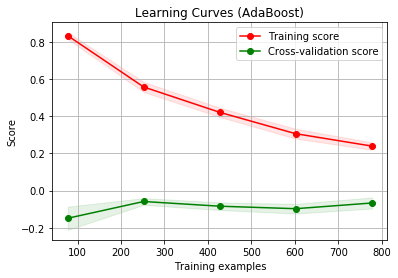

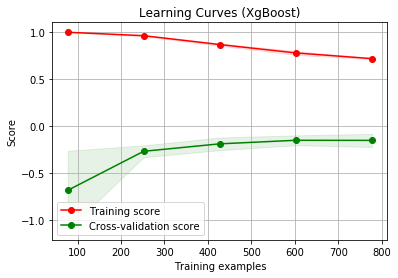

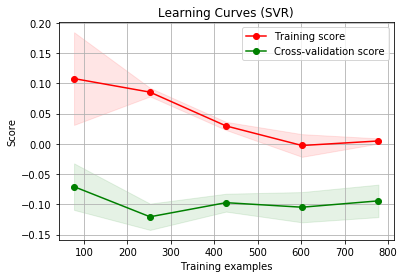

In [166]:
print()
print("========== Learning Curves ==========")
print()
plot_learning_curve(estimator=adaBoost, title="Learning Curves (AdaBoost)", X=X_train_pca, y=y_train, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(estimator=xgb, title="Learning Curves (XgBoost)", X=X_train_pca, y=y_train, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(estimator=svr_model, title="Learning Curves (SVR)", X=X_train_pca, y=y_train, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

## Scatter Plots

In [167]:
def plotScatter(predicted, name):
    colors = ["r", "b"]
    plt.title(name + " Predicted vs Actual Sale Price")
    plt.xlabel("Actual Sale Price")
    plt.ylabel("Predicted Sale Price")
    red_patch = mpatches.Patch(color='red', label='Actual Sale Price')
    blue_patch = mpatches.Patch(color='blue', label='Predicted Sale Price')
    plt.scatter(predicted['SalePrice'], predicted['predicted'], color="r", alpha=0.5)
    plt.show()

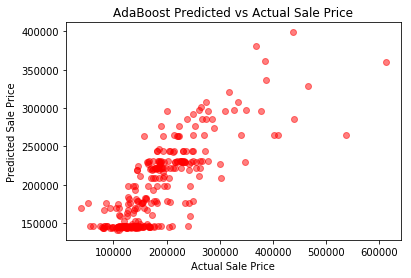

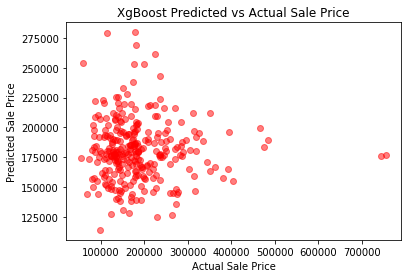

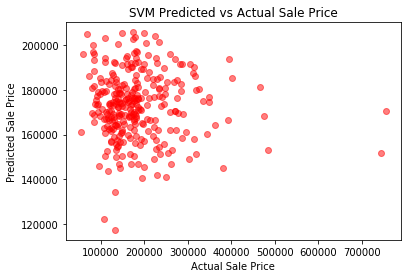

In [168]:
print()
print("========== Prediction Scatter Plots Across Models ==========")
print()

plotScatter(ada_pred, "AdaBoost")
plotScatter(xgb_pred, "XgBoost")
plotScatter(svr_pred, "SVM")

## Parameter Tuning

In [169]:
def plot_param_tuning(xgb_params, adaboost_params, svm_params):
    plt.plot(adaboost_params['parameter'], adaboost_params['rmse'], marker='o', color='b')
    plt.title("Adaboost RMSE vs n_estimators")
    plt.xlabel("n_estimators")
    plt.ylabel("RMSE")
    plt.show()
    
    plt.plot(xgb_params['parameter'], xgb_params['rmse'], marker='o', color='b')
    plt.title("XgBoost RMSE vs n_estimators")
    plt.xlabel("n_estimators")
    plt.ylabel("RMSE")
    plt.show()
    
    plt.plot(svm_params['parameter'], svm_params['rmse'], marker='o', color='b')
    plt.title("SVM RMSE vs C")
    plt.xlabel("C")
    plt.ylabel("RMSE")
    plt.show()

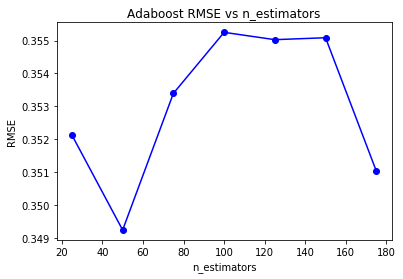

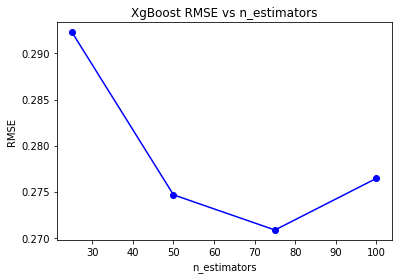

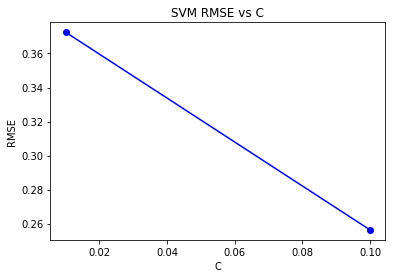

In [170]:
print()
print("========== Parameter Tuning Plots ==========")
print()

plot_param_tuning(xgb_params, adaboost_params, svm_params)